# **Kvasir image dataset classifiction**

In [1]:
#import data by kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
#kaggle imgae dataset Api
!kaggle datasets download -d meetnagadia/kvasir-dataset

100% 1.15G/1.15G [00:13<00:00, 55.2MB/s]
100% 1.15G/1.15G [00:14<00:00, 88.3MB/s]


In [4]:
#file unzip
import zipfile
zip_ref = zipfile.ZipFile('/content/kvasir-dataset.zip') 
zip_ref.extractall('/content/Data')
zip_ref.close()

In [5]:
#import libery
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from  keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Dense,Flatten,MaxPooling2D
from keras.callbacks import EarlyStopping 

In [6]:
#dataset path
path = '/content/Data/kvasir-dataset'

In [7]:
#split dataset path
train_data=tf.keras.preprocessing.image_dataset_from_directory(path,validation_split=0.2,
                                                               image_size=(224,224),
                                                               batch_size=32,
                                                               subset="training",
                                                               seed=123)

test_data=tf.keras.preprocessing.image_dataset_from_directory(path,validation_split=0.2,
                                                               image_size=(224,224),
                                                               batch_size=32,
                                                               subset="validation",
                                                               seed=123)

Found 4000 files belonging to 8 classes.
Using 3200 files for training.
Found 4000 files belonging to 8 classes.
Using 800 files for validation.


In [8]:
#check all class
class_names = train_data.class_names
class_names

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

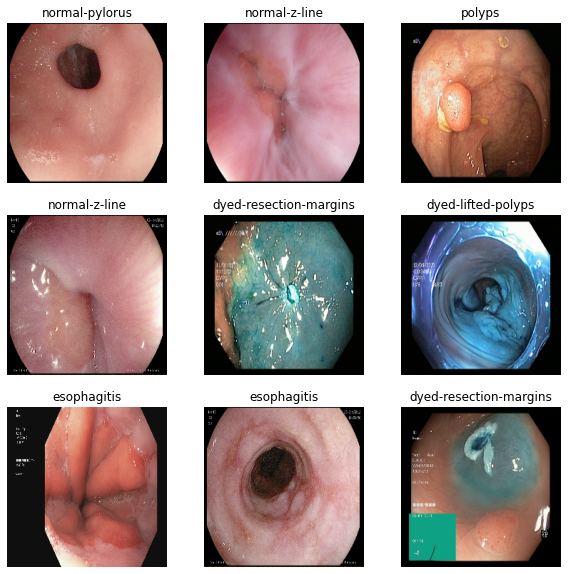

In [9]:
#image plot
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [10]:
# Criando o modelo base em cima do modelo MobileNetV3
base_model = keras.applications.MobileNetV3Small(input_shape=(224, 224, 3),
                                            classes=400,
                                            include_top=False,
                                            weights='imagenet')

4334752/4334752 [==============================] - 0s 0us/step


In [11]:
# Freeze convolutional base
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [12]:
#data augmentation
data_augmentation = keras.models.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2)
])

In [13]:
num_classes = len(class_names)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)


outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [14]:
#compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 8)                 4616      
                                                                 
Total params: 943,736
Trainable params: 4,616
Non-trainable p

In [15]:
#fitting model
initial_epochs = 10

early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

history = model.fit(train_data, 
          validation_data=test_data,
          epochs=initial_epochs,
          callbacks=[early_stop])

Epoch 1/10
100/100 [==============================] - 36s 238ms/step - loss: 1.2006 - accuracy: 0.5525 - val_loss: 0.6732 - val_accuracy: 0.7800
Epoch 2/10
100/100 [==============================] - 25s 239ms/step - loss: 0.6602 - accuracy: 0.7600 - val_loss: 0.4901 - val_accuracy: 0.8438
Epoch 3/10
100/100 [==============================] - 24s 226ms/step - loss: 0.5226 - accuracy: 0.8041 - val_loss: 0.4197 - val_accuracy: 0.8612
Epoch 4/10
100/100 [==============================] - 24s 225ms/step - loss: 0.4581 - accuracy: 0.8341 - val_loss: 0.3811 - val_accuracy: 0.8700
Epoch 5/10
100/100 [==============================] - 24s 227ms/step - loss: 0.4182 - accuracy: 0.8475 - val_loss: 0.3529 - val_accuracy: 0.8737
Epoch 6/10
100/100 [==============================] - 24s 228ms/step - loss: 0.3899 - accuracy: 0.8550 - val_loss: 0.3344 - val_accuracy: 0.8788
Epoch 7/10
100/100 [==============================] - 24s 227ms/step - loss: 0.3716 - accuracy: 0.8684 - val_loss: 0.3240 - val_ac

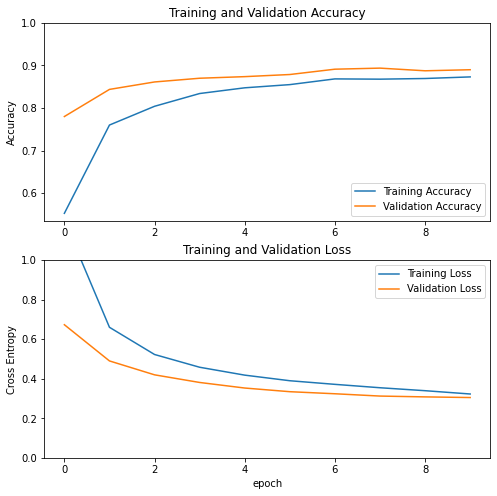

In [16]:
#check accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(test_data)
print('test accuracy : ', test_acc)

25/25 [==============================] - 5s 135ms/step - loss: 0.3049 - accuracy: 0.8900
test accuracy :  0.8899999856948853


In [19]:
#Visualize the result
results = model.evaluate(test_data, verbose=0)

In [20]:
print("Test Loss: {:.5f}".format(results[0]))
print("Accuracy on the test set: {:.2f}%".format(results[1] * 100))

Test Loss: 0.30486
Accuracy on the test set: 89.00%


1/1 [==============================] - 1s 719ms/step


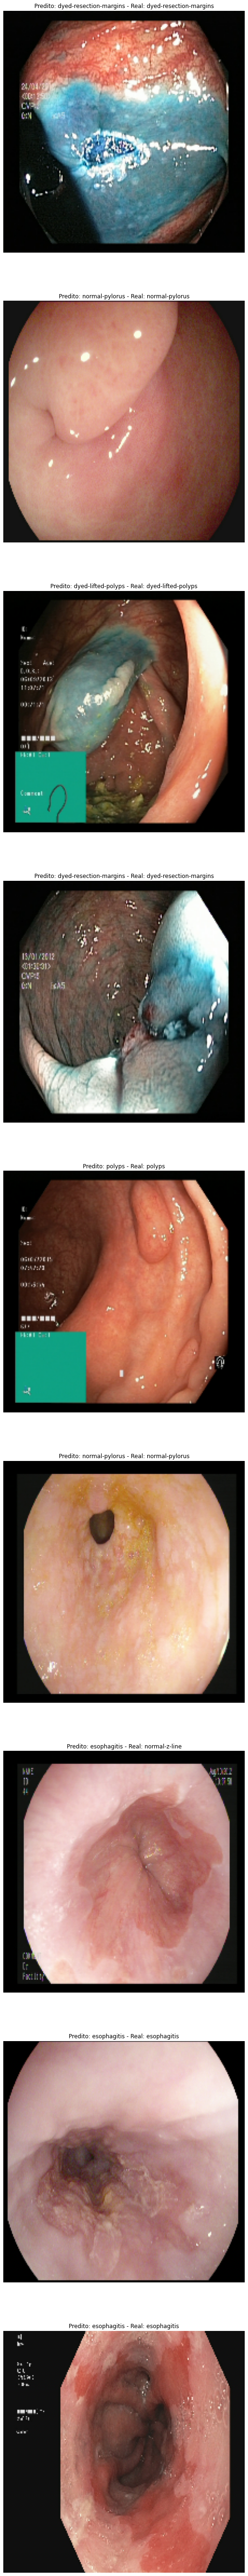

In [18]:
plt.figure(figsize=(10, 100))
for images, labels in test_data.take(1):
    prediction = model.predict(images,batch_size=32)
    for i in range(9):
        ax = plt.subplot(9, 1, i+1)
        pred = np.argmax(prediction[i])
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'Predito: {class_names[pred]} - Real: {class_names[labels[i]]}')
        plt.axis('off')